### Model

In [2]:
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense, Conv2D
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import ntpath

In [3]:
url = 'https://raw.githubusercontent.com/tzudir/Self_driving/main/data/driving_log.csv'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(url, names= columns)

In [4]:
data.head(5)

,center,left,right,steering,throttle,reverse,speed
0,C:\Users\realj\Documents\Car\IMG\center_2024_0...,C:\Users\realj\Documents\Car\IMG\left_2024_01_...,C:\Users\realj\Documents\Car\IMG\right_2024_01...,0.0,0.0,0.0,0.000091
1,C:\Users\realj\Documents\Car\IMG\center_2024_0...,C:\Users\realj\Documents\Car\IMG\left_2024_01_...,C:\Users\realj\Documents\Car\IMG\right_2024_01...,0.0,0.0,0.0,0.000116
2,C:\Users\realj\Documents\Car\IMG\center_2024_0...,C:\Users\realj\Documents\Car\IMG\left_2024_01_...,C:\Users\realj\Documents\Car\IMG\right_2024_01...,0.0,0.0,0.0,0.000132
3,C:\Users\realj\Documents\Car\IMG\center_2024_0...,C:\Users\realj\Documents\Car\IMG\left_2024_01_...,C:\Users\realj\Documents\Car\IMG\right_2024_01...,0.0,0.0,0.0,0.000161
4,C:\Users\realj\Documents\Car\IMG\center_2024_0...,C:\Users\realj\Documents\Car\IMG\left_2024_01_...,C:\Users\realj\Documents\Car\IMG\right_2024_01...,0.0,0.0,0.0,0.000227


In [5]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)

In [6]:
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2024_01_25_22_48_25_466.jpg,left_2024_01_25_22_48_25_466.jpg,right_2024_01_25_22_48_25_466.jpg,0.0,0.0,0.0,0.000091
1,center_2024_01_25_22_48_25_543.jpg,left_2024_01_25_22_48_25_543.jpg,right_2024_01_25_22_48_25_543.jpg,0.0,0.0,0.0,0.000116
2,center_2024_01_25_22_48_25_622.jpg,left_2024_01_25_22_48_25_622.jpg,right_2024_01_25_22_48_25_622.jpg,0.0,0.0,0.0,0.000132
3,center_2024_01_25_22_48_25_700.jpg,left_2024_01_25_22_48_25_700.jpg,right_2024_01_25_22_48_25_700.jpg,0.0,0.0,0.0,0.000161
4,center_2024_01_25_22_48_25_769.jpg,left_2024_01_25_22_48_25_769.jpg,right_2024_01_25_22_48_25_769.jpg,0.0,0.0,0.0,0.000227


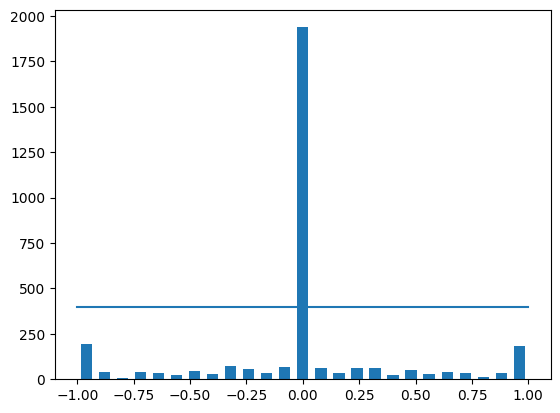

In [10]:
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center,hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])),(samples_per_bin, samples_per_bin))